In [1]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import astropy.visualization as vis

from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service
from lsst.source.injection import generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
from lsst.ip.diffim.subtractImages import AlardLuptonSubtractTask, AlardLuptonSubtractConfig
from lsst.ip.diffim.detectAndMeasure import DetectAndMeasureTask, DetectAndMeasureConfig

In [2]:
# defines a few utilities we built in the last notebook..
import gc


def query_and_table(service, query):
    return service.search(query).to_table()


def table_summary(service, table_name: str):
    s = ""
    description = service.search(
        "SELECT description "
        "FROM tap_schema.tables "
        "WHERE tap_schema.tables.schema_name = 'dp02_dc2_catalogs'" 
        f"AND table_name = 'dp02_dc2_catalogs.{table_name}'"
    ).to_table().to_pandas().iloc[0]["description"]
    s += f"{table_name}: {description}\n\n"
    for i, row in service.search(
            "SELECT column_name, datatype, description, unit "
            "FROM tap_schema.columns "
            f"WHERE table_name = 'dp02_dc2_catalogs.{table_name}'"
        ).to_table().to_pandas().iterrows():
        s += f"{row.column_name}:  {row.description} ({row.datatype})\n"
    return s
        

def sregion_to_vertices(sregion: str, closed=True):
    """Convert the s_region from the ObsCore table into two
    arrays containing the x and y vertices, in order to plot
    boxes using matplotlib.
    From Rubin DP0.2 Tutorial notebooks by the Community Science Team.
    """
    temp = sregion.split(' ')
    xvertices = []
    yvertices = []
    ix = 2
    iy = 3
    for c in range(4):
        xvertices.append(float(temp[ix]))
        yvertices.append(float(temp[iy]))
        ix += 2
        iy += 2
    if closed:
        xvertices.append(xvertices[0])
        yvertices.append(yvertices[0])
    return xvertices, yvertices


def circle_string(ra, dec, err_radius):
    return f"{ra:.4f}, {dec:.4f}, {err_radius:.4f}"


def query_obs_stdomain(service, tstart_mj, tstop_mj, ra, dec, err_radius, dp_subtype="lsst.calexp"):
    """
    Queries observation table for all pictures of type `dp_subtype` taken between 
    start_mj and stop_mj, with central spatial position falling in a circle centered
    at `ra`, `dec` with radius `err_radius`.
    """
    return query_and_table(
        service, 
        "SELECT *"
        "FROM ivoa.ObsCore "
        f"WHERE CONTAINS(POINT('ICRS', s_ra, s_dec), CIRCLE('ICRS', {circle_string(ra, dec, err_radius)}))=1 "
        f"AND t_min >= {tstart_mj} "
        f"AND t_min < {tstop_mj} "
        f"AND dataproduct_subtype = '{dp_subtype}'"
    ).to_pandas()


def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.
    From Rubin DP0.2 Tutorial notebooks by the Community Science Team.
    """
    # Get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # Clear the figure
    plt.close(fig)  # Close the figure
    gc.collect()    # Call the garbage collector


service = get_tap_service("tap")

## In previous episodes: source injection and subtraction

In this section we recover some useful code and quantities we built in our notebook on source injection, 250508_injection.ipynb. In summary, we will define coordinate for a transient close to a nearby galaxy, inject the source and construct the image difference between the injected exposure and its template.

### Transient definition

In [3]:
coord_galhost = SkyCoord(
    ra = 56.922302 * u.degree, 
    dec = -33.948517 * u.degree,
)

In [4]:
coord_transient = SkyCoord(
    ra = coord_galhost.ra - 1.3 * u.arcmin,
    dec = coord_galhost.dec, 
    frame='icrs'
)
mag_transient = 17.

In [5]:
dataId = {
    "instrument": "LSSTCam-imSim",
    "detector": 60,
    "visit": 964209,
    "band": "r",
    "physical_filter": "r_sim_1.4",
}

butler = Butler('dp02', collections='2.2i/runs/DP0.2')
calexp = butler.get("calexp", dataId=dataId)

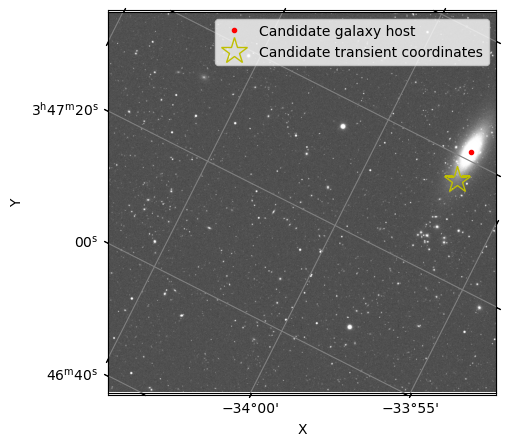

In [6]:
# plots the base image
img_wcs = WCS(calexp.getWcs().getFitsMetadata())
image_data = calexp.getImage().array
zscale = vis.ZScaleInterval()

fig, ax = plt.subplots(1, figsize=(5, 5))
plt.subplot(projection=img_wcs)
plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'ro', ms=3, label="Candidate galaxy host")
plt.plot(*img_wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Candidate transient coordinates")
limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
plt.imshow(image_data, cmap='gray', **limits)
plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
plt.grid(color='grey', ls='solid')
plt.legend()
plt.show()

remove_figure(fig)

### Source injection

In [7]:
def inject_star_source(calexp, ra, dec, mag):
    EPSILON = 10**-7
    injection_catalog = generate_injection_catalog(
        ra_lim=[ra, ra + EPSILON],
        dec_lim=[dec, dec + EPSILON],
        number=1,
        source_type="Star",
        mag=[mag],
    )
    inject_config = VisitInjectConfig()
    inject_task = VisitInjectTask(config=inject_config)
    injected_output = inject_task.run(
        injection_catalogs=injection_catalog,
        input_exposure=calexp.clone(),
        psf=calexp.getPsf(),
        photo_calib=calexp.getPhotoCalib(),
        wcs=calexp.getWcs(),
    )
    return injected_output.output_exposure, injected_output.output_catalog

calexp_injected, calexp_catalog = inject_star_source(calexp, coord_transient.ra.deg, coord_transient.dec.deg, mag_transient)

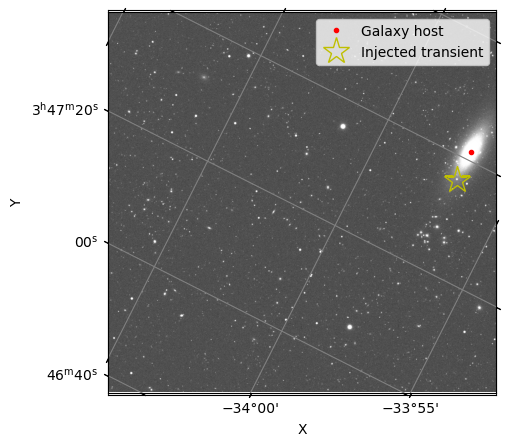

In [8]:
# plots the image with injected source
img_wcs = WCS(calexp_injected.getWcs().getFitsMetadata())
image_data = calexp_injected.getImage().array
zscale = vis.ZScaleInterval()

fig, ax = plt.subplots(1, figsize=(5, 5))
plt.subplot(projection=img_wcs)
plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'ro', ms=3, label="Galaxy host")
plt.plot(*img_wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Injected transient")
limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
plt.imshow(image_data, cmap='gray', **limits)
plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
plt.grid(color='grey', ls='solid')
plt.legend()
plt.show()
remove_figure(fig)

### Image subtraction

In [9]:
sources = butler.get('src', dataId=dataId)
template = butler.get("goodSeeingDiff_templateExp", dataId=dataId)

config = AlardLuptonSubtractConfig()
config.sourceSelector.value.unresolved.name = 'base_ClassificationExtendedness_value'
alTask = AlardLuptonSubtractTask(config=config)
difference = alTask.run(template, calexp_injected, sources)
calexp_difference = difference.difference

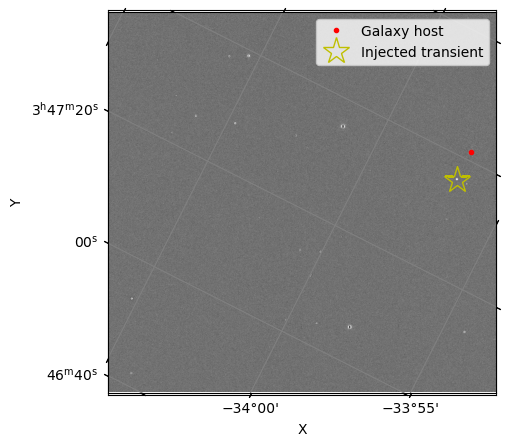

In [10]:
# plots the image difference
img_wcs = WCS(calexp_difference.getWcs().getFitsMetadata())
image_data = calexp_difference.getImage().array
zscale = vis.ZScaleInterval()

fig, ax = plt.subplots(1, figsize=(5, 5))
plt.subplot(projection=img_wcs)
plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'ro', ms=3, label="Galaxy host")
plt.plot(*img_wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Injected transient")
limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
plt.imshow(image_data, cmap='gray', **limits)
plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
plt.grid(color='grey', ls='solid')
plt.legend()
plt.show()
remove_figure(fig)

# Difference Image Analysis

The official tutorial notebook on source detection is weird. It does not work with difference images, so I'm wondering if we should be working with these at all. However, the `diffim` package from the LSST pipeline contains routines for source detection on difference image, see [this](https://github.com/lsst/ip_diffim/blob/main/python/lsst/ip/diffim/detectAndMeasure.py) page. They are scarcely documented but usable. Let's try to use it.

In [11]:
config = DetectAndMeasureConfig()
print(f"`DetectAndMeasure` config value: {config.detection.thresholdValue}")
print(f"`DetectAndMeasure` threshold type: {config.detection.thresholdType}")
print(f"`DetectAndMeasure` polarity type: {config.detection.thresholdPolarity}")

# the next line should select only positive sources but it's causing an error. maybe open an issue
# config.detection.thresholdPolarity = "positive"
results = DetectAndMeasureTask(config=config).run(calexp_injected, template, calexp_difference)

`DetectAndMeasure` config value: 5.0
`DetectAndMeasure` threshold type: pixel_stdev
`DetectAndMeasure` polarity type: both


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


This is an excerpt of what we got:

In [12]:
diaSources_lg_df = results.getDict()["diaSources"].asAstropy().to_pandas()
diaSources_lg_df.head()

,id,coord_ra,coord_dec,parent,coord_raErr,coord_decErr,coord_ra_dec_Cov,is_negative,detect_isPrimary,base_SdssCentroid_x,...,ip_diffim_forced_PsfFlux_instFlux,ip_diffim_forced_PsfFlux_instFluxErr,ip_diffim_forced_PsfFlux_area,ip_diffim_forced_PsfFlux_flag,ip_diffim_forced_PsfFlux_flag_noGoodPixels,ip_diffim_forced_PsfFlux_flag_edge,refMatchId,srcMatchId,merge_footprint_positive,merge_footprint_negative
0,2,0.990230,-0.593444,0,1.677368e-07,2.116836e-07,2.202644e-15,False,False,1698.243285,...,2.124574e+05,691.254437,39.299316,False,False,False,0,0,True,False
1,3,0.991558,-0.591437,0,NaN,NaN,NaN,False,False,4051.014703,...,9.992377e+05,1471.756292,40.320412,True,False,True,0,0,True,True
2,4,0.989463,-0.594899,0,NaN,NaN,NaN,False,False,60.956102,...,1.288185e+06,1667.541935,39.478832,False,False,False,0,0,True,True
3,8,0.990936,-0.592827,0,2.626511e-07,3.219140e-07,1.931341e-15,False,False,2538.079052,...,1.473513e+03,234.013466,39.561092,False,False,False,0,0,True,False
4,11,0.991245,-0.593396,0,NaN,NaN,NaN,False,False,2127.223634,...,2.694881e+04,263.170695,39.504795,False,False,False,0,0,True,True


The table is huge and contains many columns of dubious value. Some of the column values needs conversion. We fix it and remove the anomalies with negative polarity.

In [13]:
_df = diaSources_lg_df
_d = {
    "is_negative": _df["is_negative"],
    "coord_ra": np.rad2deg(_df["coord_ra"]),
    "coord_dec": np.rad2deg(_df["coord_dec"]),
    "PsfFlux_base": _df["base_PsfFlux_instFlux"],
    "PsfFlux_baseErr": _df["base_PsfFlux_instFluxErr"],
    "PsfFlux_diffim": _df["ip_diffim_forced_PsfFlux_instFlux"],
    "PsfFlux_diffimErr": _df["ip_diffim_forced_PsfFlux_instFluxErr"],
    "snr_diffim": _df["ip_diffim_forced_PsfFlux_instFlux"] / _df["ip_diffim_forced_PsfFlux_instFluxErr"],
    "snr_base": _df["base_PsfFlux_instFlux"] / _df["base_PsfFlux_instFluxErr"],
}
diaSources_df = pd.DataFrame(_d).sort_values("snr_base", ascending=False)

# comment to keep negative sources
# diaSources_df = diaSources_df[~diaSources_df["is_negative"]]
# diaSources_df = diaSources_df.drop(columns=["is_negative"])
diaSources_df.head()

,is_negative,coord_ra,coord_dec,PsfFlux_base,PsfFlux_baseErr,PsfFlux_diffim,PsfFlux_diffimErr,snr_diffim,snr_base
11,False,56.900636,-33.948517,1.179495e+06,1585.042516,1.186258e+06,1587.403566,747.294826,744.140758
13,False,56.878835,-33.995991,8.855179e+04,2130.106679,2.065068e+06,2110.593329,978.430064,41.571530
10,False,56.900941,-33.942121,8.397084e+04,2203.335160,2.173672e+06,2181.495015,996.414082,38.110788
19,False,56.864645,-34.116765,2.865358e+04,2062.802536,1.932044e+06,2039.705455,947.217334,13.890606
0,False,56.735974,-34.001814,6.502495e+03,697.263446,2.124574e+05,691.254437,307.350569,9.325736


The table is missing a column for magnitude. There are two ways to add it.

Either we manually compute from the formula:

$$ m = -2.5 \log_{10}(\frac{F}{\tau_{\text{exp}}}) + m_0$$

In [14]:
# there is a zeropoint attribute in `SummaryStats`
print(f"Summary zeropoint value is: {calexp.getInfo().getSummaryStats().zeroPoint}")
# which is also reachable from the image metadata
_t_exp = 30
print(f"Manually computed zeropoint value is: {calexp.getInfo().getMetadata()["MAGZERO"] + 2.5 * np.log10(_t_exp)}")
# the there are information on the exposure time too but for some reason they were set to NaN
print(f"Summary expTime value is: {calexp.getInfo().getSummaryStats().expTime}")

Summary zeropoint value is: 32.18004232509944
Manually computed zeropoint value is: 32.18004232509946
Summary expTime value is: nan


In [15]:
mag =  -2.5 * np.log10(diaSources_df["PsfFlux_diffim"]) + calexp.getInfo().getSummaryStats().zeroPoint

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Or we use the a dedicated calexp method, which has the pro of not raising warnings when flux is negative.

In [16]:
mag_ = [calexp.getPhotoCalib().instFluxToMagnitude(f) for f in diaSources_df["PsfFlux_diffim"]]

The two methods are otherwise equivalent:

In [17]:
np.isclose(np.max(mag_ - mag), 0)

np.True_

We add the magnitude column to our dataframe, and errors associated to it, and filter out negative anomalous sources.

In [18]:
diaSources_df["mag_base"] = [
    calexp.getPhotoCalib().instFluxToMagnitude(f) 
    for f in diaSources_df["PsfFlux_base"]
]
diaSources_df["mag_base_errBot"] = [
    calexp.getPhotoCalib().instFluxToMagnitude(f + delta_f) 
    for f, delta_f in zip(diaSources_df["PsfFlux_base"], diaSources_df["PsfFlux_baseErr"],)
]
diaSources_df["mag_base_errTop"] = [
    calexp.getPhotoCalib().instFluxToMagnitude(f - delta_f) 
    for f, delta_f in zip(diaSources_df["PsfFlux_base"], diaSources_df["PsfFlux_baseErr"],)
]


diaSources_df["mag_diffim"] = [
    calexp.getPhotoCalib().instFluxToMagnitude(f) 
    for f in diaSources_df["PsfFlux_diffim"]
]
diaSources_df["mag_diffim_errBot"] = [
    calexp.getPhotoCalib().instFluxToMagnitude(f + delta_f) 
    for f, delta_f in zip(diaSources_df["PsfFlux_diffim"], diaSources_df["PsfFlux_diffim"],)
]
diaSources_df["mag_diffim_errTop"] = [
    calexp.getPhotoCalib().instFluxToMagnitude(f - delta_f) 
    for f, delta_f in zip(diaSources_df["PsfFlux_diffim"], diaSources_df["PsfFlux_diffimErr"],)
]

# i have removed the columns relative to magnitude error extension, to keep this cell at size.
# i think it should not be a great problem since we can compute them readily from the data 
# already present, when needed. gd.
diaSources_df

,is_negative,coord_ra,coord_dec,PsfFlux_base,PsfFlux_baseErr,PsfFlux_diffim,PsfFlux_diffimErr,snr_diffim,snr_base,mag_base,mag_base_errBot,mag_base_errTop,mag_diffim,mag_diffim_errBot,mag_diffim_errTop
11,False,56.900636,-33.948517,1.179495e+06,1585.042516,1.186258e+06,1587.403566,747.294826,744.140758,17.000802,16.999344,17.002262,16.994594,16.242019,16.996048
13,False,56.878835,-33.995991,8.855179e+04,2130.106679,2.065068e+06,2110.593329,978.430064,41.571530,19.812049,19.786241,19.838485,16.392706,15.640131,16.393817
10,False,56.900941,-33.942121,8.397084e+04,2203.335160,2.173672e+06,2181.495015,996.414082,38.110788,19.869721,19.841599,19.898590,16.337057,15.584482,16.338147
19,False,56.864645,-34.116765,2.865358e+04,2062.802536,1.932044e+06,2039.705455,947.217334,13.890606,21.037095,20.961617,21.118215,16.465000,15.712425,16.466146
0,False,56.735974,-34.001814,6.502495e+03,697.263446,2.124574e+05,691.254437,307.350569,9.325736,22.647342,22.536748,22.770493,18.861862,18.109287,18.865401
20,False,56.880746,-34.135867,2.311121e+03,250.189088,4.991528e+03,247.968260,20.129706,9.237499,23.770485,23.658887,23.894883,22.934459,22.181884,22.989781
18,False,56.891068,-34.033815,1.221150e+03,235.701074,1.205338e+03,232.321345,5.188237,5.180926,24.463120,24.271505,24.695957,24.477270,23.724695,24.709741
3,False,56.776472,-33.966500,1.195567e+03,235.841302,1.473513e+03,234.013466,6.296702,5.069373,24.486107,24.290633,24.724674,24.259157,23.506582,24.446926
8,False,56.848849,-34.007802,2.099257e+03,420.567673,6.366639e+04,415.907083,153.078395,4.991484,23.874878,23.676617,24.117617,20.170267,19.417692,20.177383
14,False,56.873320,-34.034913,3.706454e+03,747.289292,3.261558e+05,740.898030,440.216789,4.959865,23.257646,23.058229,23.502119,18.396480,17.643905,18.398949


We can see that the detected source with the highest SNR (first in the table above)  is at the injected transient location which is cool.

In [19]:
coord_transient, mag_transient

(<SkyCoord (ICRS): (ra, dec) in deg
     (56.90063533, -33.948517)>,
 17.0)

Now let's plot what we got onto the difference image.

In [20]:
def plot_calexp_and_anomalies(calexp, anomalies: pd.DataFrame):
    img_wcs = WCS(calexp.getWcs().getFitsMetadata())
    image_data = calexp.getImage().array
    zscale = vis.ZScaleInterval()
    limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}

    fig, ax = plt.subplots(1, figsize=(8, 8))
    plt.subplot(projection=img_wcs)
    plt.imshow(image_data, cmap='gray', **limits)
    plt.plot(*img_wcs.world_to_pixel(coord_transient), 'y*', markerfacecolor="None", ms=20, label="Injected transient")
    plt.plot(*img_wcs.world_to_pixel(coord_galhost), 'ro', ms=3, label="Galaxy host")
    for _, source in anomalies.iterrows():
        coord_source = SkyCoord(
            ra = source["coord_ra"] * u.deg,
            dec = source["coord_dec"] * u.deg,
            frame='icrs'
        )
        plt.plot(*img_wcs.world_to_pixel(coord_source), 'ko', markerfacecolor="None", ms=10)
    
    limits = {"vmin": (_lims := zscale.get_limits(image_data))[0], "vmax": _lims[1]}
    plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
    plt.grid(color='grey', ls='solid')
    plt.legend()
    plt.show()
    remove_figure(fig)
    return

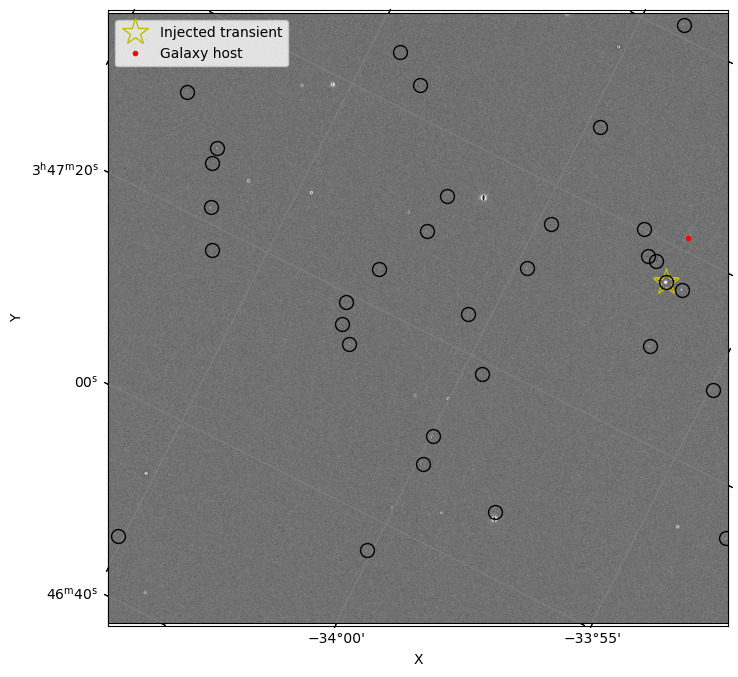

In [21]:
plot_calexp_and_anomalies(calexp_difference, diaSources_df)

---
### Warning!

⚠️  Even if the configuration threshold is set to 5 sigma we got a lot of sources with snr between -5 and +5. Why? Are we correctly computing the SNR?

⚠️  `detectAndMeasure` returns different istantaneous flux values. These are apparently computed by different function. Our tests suggest that `ip_diffim_forced_PsfFlux_instFlux` is computed on the science image, and that `base_PsfFlux_instFlux` is computed on the difference image. However we are not still 100% on what's going on with these so we are annotating the function prefix (`base`, `diffim`) in the snr/magnitude columns.

---

## Anomalies filtering

The goal of this section is to clean the output of `detectAndMeasure`, filtering out anomalous sources which could originate from star sources, or other image artifact.

### 1. Negative sources

These should not be there in first place but, as we just noted, the configuration polarity selector does not work as intended. This said, it's still easy to remove negative anomalies because they are flagged.

In [22]:
# a wrapper for making sure how many sources we cut at each step
def verbose(func):
    def msg_wrapper(df: pd.DataFrame, *args, **kwargs):
        before_cut = len(df)
        df = func(df, *args, *kwargs)
        after_cut = len(df)
        print(f"{func.__name__} cut {before_cut - after_cut} rows")
        return df
    return msg_wrapper

In [23]:
@verbose
def filter_nonneg(df: pd.DataFrame) -> pd.DataFrame:
    mask = ~df["is_negative"]
    return df[mask].drop(columns=["is_negative"]).reset_index(drop=True)

diaSources_df_ = filter_nonneg(diaSources_df)

filter_nonneg cut 9 rows


### 2. Sources with negative difference flux

There are a few "donut" sources with negative flux as measured in the difference image. We filter them too.

In [24]:
@verbose
def filter_donut(df: pd.DataFrame) -> pd.DataFrame:  
    mask = df["PsfFlux_base"] > 0
    return df[mask].reset_index(drop=True)

diaSources_df_ = filter_donut(diaSources_df_)

filter_donut cut 8 rows


### 3. Mask values

Let's take a look at the masks that come with calexp. We will define two functions, one for getting a mask plane and another for getting the mask keyword bit at a sky coordinate.

In [25]:
def get_mask(calexp, mask_name: str) -> np.ndarray:
    mask = calexp.getMask()
    target_bit = mask.getMaskPlane(mask_name)
    mask_array = mask.getArray()
    return (mask_array & (2 ** target_bit)) != 0

def coord_to_pix(calexp, ra, dec) -> tuple[int, int]:
    wcs = WCS(calexp.getWcs().getFitsMetadata())
    coord = SkyCoord(
        ra = ra * u.deg,
        dec = dec * u.deg
    )
    i, j = wcs.world_to_array_index(coord)
    # apparently can return pixel at boundary
    return min(i, calexp.getHeight() - 1), min(j, calexp.getWidth() - 1), 

def get_mask_value_coord(calexp, ra, dec) -> int:
    return calexp.getMask()[*coord_to_pix(calexp, ra, dec)]

def get_mask_labels_coord(calexp, ra, dec) -> list[str]:
    return [
        keyword 
        for keyword, bit in calexp.getMask().getMaskPlaneDict().items() 
        if get_mask_value_coord(calexp, ra, dec) & (2 ** bit) != 0
    ]    

The mask keywords and bit are stored in a dictionary and are easy to retrieve.

In [26]:
calexp.getMask().getMaskPlaneDict()

{'BAD': 0,
 'CLIPPED': 16,
 'CR': 3,
 'CROSSTALK': 11,
 'DETECTED': 5,
 'DETECTED_NEGATIVE': 6,
 'EDGE': 4,
 'INEXACT_PSF': 17,
 'INJECTED': 14,
 'INJECTED_CORE': 15,
 'INJECTED_CORE_TEMPLATE': 22,
 'INJECTED_TEMPLATE': 21,
 'INTRP': 2,
 'NOT_DEBLENDED': 12,
 'NO_DATA': 8,
 'REJECTED': 18,
 'SAT': 1,
 'SAT_TEMPLATE': 20,
 'SENSOR_EDGE': 19,
 'STREAK': 10,
 'SUSPECT': 7,
 'UNMASKEDNAN': 13,
 'VIGNETTED': 9}

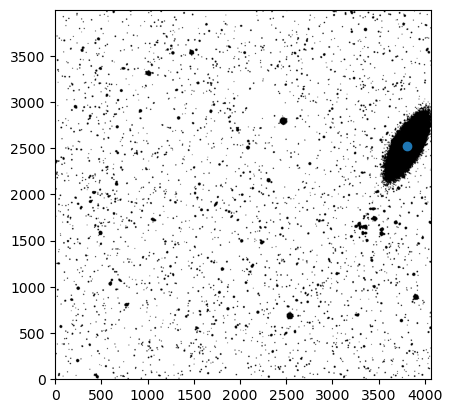

In [27]:
plt.imshow(get_mask(calexp, "DETECTED"), cmap="binary", origin="lower")
plt.scatter(*coord_to_pix(calexp, coord_galhost.ra.deg, coord_galhost.dec.deg)[::-1])
plt.show()

Our anomalies do not fall over pixels with bad mask values, but here's some function to check if they do, adding flags to the anomalies dataframe.

NB: In previous versions of this notebook we indeed found anomalies to match bad mask pixels. This was due to an error in `coord_to_pix`, which returned pixel as customary with graphics, e.g. `(x, -y)`, rather than array indexes, e.g. `(i, j)`.

In [28]:
def insert_mask_keywords(df: pd.DataFrame) -> pd.DataFrame:
    # not in-place
    keywords: list[list[str]] = [get_mask_labels_coord(calexp, ra, dec) for ra, dec in df[["coord_ra", "coord_dec"]].values]
    return pd.concat(
        (df,
        pd.DataFrame({
                f"mask_{k}": [1 if k in ks else 0 for ks in keywords ]
                for k in set([k for ks in keywords for k in ks])
        })),
        axis=1,
    ).reset_index(drop=True)

diaSources_df_ = insert_mask_keywords(diaSources_df_)

In [29]:
diaSources_df_.columns

Index(['coord_ra', 'coord_dec', 'PsfFlux_base', 'PsfFlux_baseErr',
       'PsfFlux_diffim', 'PsfFlux_diffimErr', 'snr_diffim', 'snr_base',
       'mag_base', 'mag_base_errBot', 'mag_base_errTop', 'mag_diffim',
       'mag_diffim_errBot', 'mag_diffim_errTop'],
      dtype='object')

We can filter out sources with bad mask values.

In [30]:
@verbose
def filter_badmask(anomalies, keywords: list[str]):
    mask_cols = [f"mask_{k}" for k in keywords if f"mask_{k}" in anomalies.columns]
    if not mask_cols:
        return anomalies.copy()
    rows_to_drop = (anomalies[mask_cols] == 1).any(axis=1)
    return anomalies[~rows_to_drop].reset_index(drop=True)

bad_keywords = ["SAT", "CROSSTALK", "CR", "BAD", "STREAK", ]
diaSources_df_ = filter_badmask(diaSources_df_, bad_keywords)

filter_badmask cut 0 rows


We didn't presently filter any, but this logic may turn out useful in the future.

### 4. Closeness to stars

Unfortunately we cannot simply rely on the `DETECTED` mask value for removing anomalies with no known counterparts: the source could be overimposed to an extended objects (e.g., a galaxy). To catch these kind of anomalies we shall first compare their position against that of catalogue stars. In previous versions of this notebook, we did use information from the truth tables. I think we should rather not: we will not have these information, if not in form of third-party catalogs. Hence for now on, we will limit ourself to use info only from the `Object` catalog.

In [ ]:
s_region = "POLYGON ICRS 56.772371 -33.853414 56.633431 -34.079736 56.902664 -34.193001 57.041067 -33.966365"
query = (
    "SELECT obj.coord_ra AS coord_ra, "
    "obj.coord_dec AS coord_dec, "
    "obj.r_extendedness AS r_extendedness, "
    "scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS cModelMag_r, "
    "obj.r_cModelFlux AS r_cModelFlux "
    "FROM dp02_dc2_catalogs.Object AS obj "
    "WHERE CONTAINS(POINT('ICRS', obj.coord_ra, obj.coord_dec), POLYGON('ICRS', 56.772371, -33.853414, 56.633431, -34.079736, 56.902664, -34.193001, 57.041067, -33.966365)) = 1 "
    "AND obj.detect_isPrimary = 1 "
    "AND obj.r_extendedness = 0 "  # this is our supposed handle on stars
)

stars_df = query_and_table(service, query).to_pandas()
stars_df.shape

In [ ]:
@verbose
def filter_nearsources_simpledist(
    anomalies: pd.DataFrame,
    catalog: pd.DataFrame,
    tolerance_arcsec: float = 0.2, # pixel size
) -> pd.DataFrame:
    source_coords = anomalies[["coord_ra", "coord_dec"]].values
    ref_coords = catalog[["coord_ra", "coord_dec"]].values
    tolerance_deg = tolerance_arcsec / 3600.0
    diffs = source_coords[:, np.newaxis, :] - ref_coords[np.newaxis, :, :]
    is_match = np.any(
        (np.abs(diffs[:, :, 0]) < tolerance_deg) &
        (np.abs(diffs[:, :, 1]) < tolerance_deg),
        axis=1
    )
    return anomalies[~is_match]

@verbose
def filter_nearsources(
    anomalies: pd.DataFrame,
    catalog: pd.DataFrame,
    tolerance_arcsec: float = 0.2, # pixel size
) -> pd.DataFrame:
    source_coords = anomalies[["coord_ra", "coord_dec"]].values
    ref_coords = catalog[["coord_ra", "coord_dec"]].values
    tolerance_deg = np.deg2rad(tolerance_arcsec / 3600.0)
    s_ = np.deg2rad(source_coords[:, np.newaxis, :])
    r_ = np.deg2rad(ref_coords[np.newaxis, :, :])
    distances = np.acos(np.sin(s_[:, :, 1]) * np.sin(r_[:, :, 1]) + np.cos(s_[:, :, 1]) * np.cos(r_[:, :, 1]) * np.cos(s_[:, :, 0] - r_[:, :, 0]))
    is_match = np.any(distances  < tolerance_deg, axis=1)
    return anomalies[~is_match]

# for checking that both give same result, as we expect for small tolerance value
_ = filter_nearsources_simpledist(diaSources_df_, stars_df)
# finally apply the actual source cut
diaSources_df_ = filter_nearsources(diaSources_df_, stars_df)

### 4. Proximity to extended objects

The goal here is to keep only those anomalies which are near an extended object. First we select all galaxy objects. They are quite a lot and it's crucial that we identify solutions to select a manageable number of extend object to put in our analysis

In [ ]:
s_region = "POLYGON ICRS 56.772371 -33.853414 56.633431 -34.079736 56.902664 -34.193001 57.041067 -33.966365"
query = (
    "SELECT obj.coord_ra AS coord_ra, "
    "obj.coord_dec AS coord_dec, "
    "obj.r_extendedness AS r_extendedness, "
    "obj.footprintArea AS footprintArea, "
    "scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS cModelMag_r, "
    "obj.r_cModelFlux AS r_cModelFlux "
    "FROM dp02_dc2_catalogs.Object AS obj "
    "WHERE CONTAINS(POINT('ICRS', obj.coord_ra, obj.coord_dec), POLYGON('ICRS', 56.772371, -33.853414, 56.633431, -34.079736, 56.902664, -34.193001, 57.041067, -33.966365)) = 1 "
    "AND obj.detect_isPrimary = 1 "
    "AND obj.r_extendedness = 1 "  # galaxies
    # this is completely arbitrary: we need a meaningful condition to reduce the size of this table!
    "AND footprintArea > 4000 " 
)

galaxies_df = query_and_table(service, query).to_pandas()
galaxies_df.shape

The idea of the filter is simple. We will AND sources in the galaxies dataframe with the calexp detected mask, keeping only those connected regions in the detected masks which also contain an extended object. 

This is a VERY crude, slow implementation. We can do much better. Yet it will be crucial to keep the size of `galaxies_df` manageable.

In [ ]:
from scipy.ndimage import label
from tqdm.notebook import tqdm

mask_detected = get_mask(calexp, "DETECTED").astype(int)
labelled, nlabels = label(mask_detected)
out = np.zeros_like(labelled).astype(bool)
for i, source in tqdm(galaxies_df.iterrows()):
    ra, dec = source[["coord_ra", "coord_dec"]].values
    if not calexp.containsSkyCoords(ra * u.deg, dec * u.deg):
        continue
    pixel = coord_to_pix(calexp, ra, dec)
    label = labelled[*pixel]
    if label == 0:
        continue
    out |= labelled == label

In [ ]:
plt.subplots(figsize=(10, 10))
plt.imshow(out, origin="lower", cmap="binary")
plt.show()

In [ ]:
@verbose
def filter_extprox(df: pd.DataFrame) -> pd.DataFrame:
    mask = df[["coord_ra", "coord_dec"]].apply(lambda x: out[*coord_to_pix(calexp, x.coord_ra, x.coord_dec)], axis=1)
    return df[mask].reset_index(drop=True)

diaSources_df_ = filter_extprox(diaSources_df_)

In [ ]:
diaSources_df_

In [ ]:
plot_calexp_and_anomalies(template, diaSources_df_)

In [ ]:
plot_calexp_and_anomalies(calexp_injected, diaSources_df_)

In [ ]:
plot_calexp_and_anomalies(calexp_difference, diaSources_df_)

This is what we end with, after our filtering pipeline. The anomalies sample contains our injected sources, but also other anomalies. **What are these? Have we filtered out any sane transients?**